## 목차
### 1. Library Import
### 2. 학습데이터 생성
### 3. Light-gbm 모델 훈련
### 4. 교차 검증 점수 확인
### 5. 제출 파일 생성

# 1. Library Import

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


PATH = './'

# 2. 학습 데이터 생성

2.0 train_qual

In [3]:
train_qual  = pd.read_csv(PATH+'train_quality_data.csv', thousands = ',')
display(train_qual.head())

time  user_id       fwver  quality_0  quality_1  quality_2  \
0  20201129090000    10000  05.15.2138        0.0          0        0.0   
1  20201129090000    10000  05.15.2138        0.0          0        0.0   
2  20201129090000    10000  05.15.2138        0.0          0        0.0   
3  20201129090000    10000  05.15.2138        0.0          0        0.0   
4  20201129090000    10000  05.15.2138        0.0          0        0.0   

   quality_3  quality_4  quality_5  quality_6  quality_7  quality_8  \
0          0          0        0.0          0          0          0   
1          0          0        0.0          0          0          0   
2          0          0        0.0          0          0          0   
3          0          0        0.0          0          0          0   
4          0          0        0.0          0          0          0   

   quality_9  quality_10  quality_11  quality_12  
0          0           4           0           0  
1          0           4           0           0  
2          0           4           0           0  
3          0           4           0           0  
4          0           4           0           0

In [4]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  float64
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  int64  
 11  quality_8   828624 non-null  int64  
 12  quality_9   828624 non-null  int64  
 13  quality_10  828624 non-null  int64  
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(3), int64(12), object(1)
memory usage: 101.2+ MB


In [5]:
train_qual['quality_0'][(train_qual['quality_0'] >= 10) & (train_qual['quality_0'] <= 99)] = 10
train_qual['quality_0'][(train_qual['quality_0'] >= 100) & (train_qual['quality_0'] <= 999)] = 11
train_qual['quality_0'][(train_qual['quality_0'] >= 1000) & (train_qual['quality_0'] <= 9999)] = 12
train_qual['quality_0'][(train_qual['quality_0'] >= 10000) & (train_qual['quality_0'] <= 99999)] = 13
train_qual['quality_0'][train_qual['quality_0'] >= 100000] = 14
train_qual['quality_0'][train_qual['quality_0'].isnull()] = 15
train_qual['quality_0'][train_qual['quality_0'] == -1] = 16
train_qual['quality_0'] = train_qual['quality_0'].astype(int)

print(train_qual.quality_0.value_counts().sort_index())
print(train_qual.quality_0.value_counts().sort_index().sum())

0     542790
1       2097
2       1252
3        518
4        410
5        385
6        358
7        314
8        268
9        298
10      3445
11      1012
12       172
13        39
14         6
15    144432
16    130828
Name: quality_0, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from th

In [6]:
train_qual['quality_1'][(train_qual['quality_1'] >= 10) & (train_qual['quality_1'] <= 99)] = 10
train_qual['quality_1'][(train_qual['quality_1'] >= 100) & (train_qual['quality_1'] <= 999)] = 11
train_qual['quality_1'][(train_qual['quality_1'] >= 1000)] = 12
train_qual['quality_1'][train_qual['quality_1'].isnull()] = 13
train_qual['quality_1'][train_qual['quality_1'] == -1] = 14

print(train_qual.quality_1.value_counts().sort_index())
print(train_qual.quality_1.value_counts().sort_index().sum())

0     670270
1       2567
2       1140
3        391
4        202
5        134
6         71
7         50
8         35
9         26
10        81
11         8
14    153649
Name: quality_1, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from th

In [7]:
train_qual['quality_2'][(train_qual['quality_2'] >= 10) & (train_qual['quality_2'] <= 99)] = 10
train_qual['quality_2'][(train_qual['quality_2'] >= 100) & (train_qual['quality_2'] <= 999)] = 11
train_qual['quality_2'][(train_qual['quality_2'] >= 1000) & (train_qual['quality_2'] <= 9999)] = 12
train_qual['quality_2'][(train_qual['quality_2'] >= 10000) & (train_qual['quality_2'] <= 99999)] = 13
train_qual['quality_2'][train_qual['quality_2'] >= 100000] = 14
train_qual['quality_2'][train_qual['quality_2'].isnull()] = 15
train_qual['quality_2'][train_qual['quality_2'] == -1] = 16
train_qual['quality_2'] = train_qual['quality_2'].astype(int)

print(train_qual.quality_2.value_counts().sort_index())
print(train_qual.quality_2.value_counts().sort_index().sum())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0     632469
1       2937
2       1073
3        580
4        455
5        427
6        386
7        337
8        285
9        314
10      3561
11      1032
12       210
13        42
14        11
15     40113
16    144392
Name: quality_2, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [8]:
train_qual['quality_5'][(train_qual['quality_5'] >= 10) & (train_qual['quality_5'] <= 99)] = 10
train_qual['quality_5'][(train_qual['quality_5'] >= 100) & (train_qual['quality_5'] <= 999)] = 11
train_qual['quality_5'][(train_qual['quality_5'] >= 1000) & (train_qual['quality_5'] <= 9999)] = 12
train_qual['quality_5'][(train_qual['quality_5'] >= 10000) & (train_qual['quality_5'] <= 99999)] = 13
train_qual['quality_5'][train_qual['quality_5'] >= 100000] = 14
train_qual['quality_5'][train_qual['quality_5'].isnull()] = 15
train_qual['quality_5'][train_qual['quality_5'] == -1] = 16
train_qual['quality_5'] = train_qual['quality_5'].astype(int)

print(train_qual.quality_5.value_counts().sort_index())
print(train_qual.quality_5.value_counts().sort_index().sum())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from th

0     428096
1      56171
2      35978
3      21596
4      11204
5       8536
6       6836
7       5506
8       4495
9       4114
10     64444
11     22704
12      4631
13       872
14        67
15        20
16    153354
Name: quality_5, dtype: int64
828624


In [9]:
train_qual['quality_6'][(train_qual['quality_6'] >= 10) & (train_qual['quality_6'] <= 99)] = 10
train_qual['quality_6'][(train_qual['quality_6'] >= 100) & (train_qual['quality_6'] <= 999)] = 11
train_qual['quality_6'][train_qual['quality_6'] == -1] = 12

print(train_qual.quality_6.value_counts().sort_index())
print(train_qual.quality_6.value_counts().sort_index().sum())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0     662217
1       1347
2        603
3        475
4        408
5        644
6        445
7        236
8        178
9        195
10      4628
11      3717
12    153531
Name: quality_6, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
train_qual['quality_7'][(train_qual['quality_7'] >= 10) & (train_qual['quality_7'] <= 99)] = 10
train_qual['quality_7'][(train_qual['quality_7'] >= 100) & (train_qual['quality_7'] <= 999)] = 11
train_qual['quality_7'][(train_qual['quality_7'] >= 1000) & (train_qual['quality_7'] <= 9999)] = 12
train_qual['quality_7'][train_qual['quality_7'] == -1] = 13


print(train_qual.quality_7.value_counts().sort_index())
print(train_qual.quality_7.value_counts().sort_index().sum())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0     757788
1       6768
2       3648
3       2568
4       2124
5       3456
6       2688
7       1164
8       1116
9       1128
10     29148
11     12240
12      4788
Name: quality_7, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [11]:
train_qual['quality_8'][(train_qual['quality_8'] >= 10) & (train_qual['quality_8'] <= 99)] = 10
train_qual['quality_8'][(train_qual['quality_8'] >= 100) & (train_qual['quality_8'] <= 999)] = 11
train_qual['quality_8'][(train_qual['quality_8'] >= 1000) & (train_qual['quality_8'] <= 9999)] = 12
train_qual['quality_8'][(train_qual['quality_8'] >= 10000)] = 13
train_qual['quality_8'][train_qual['quality_8'] == -1] = 14


print(train_qual.quality_8.value_counts().sort_index())
print(train_qual.quality_8.value_counts().sort_index().sum())

0     787812
1      19104
2       8832
3       4020
4       2592
5       1692
6       1116
7        744
8        480
9        384
10      1824
11        12
12        12
Name: quality_8, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from th

In [12]:
train_qual['quality_9'][(train_qual['quality_9'] >= 10) & (train_qual['quality_9'] <= 99)] = 10
train_qual['quality_9'][(train_qual['quality_9'] >= 100) & (train_qual['quality_9'] <= 999)] = 11
train_qual['quality_9'][(train_qual['quality_9'] >= 1000) & (train_qual['quality_9'] <= 9999)] = 12
train_qual['quality_9'][(train_qual['quality_9'] >= 10000) & (train_qual['quality_9'] <= 99999)] = 13
train_qual['quality_9'][(train_qual['quality_9'] >= 100000) & (train_qual['quality_9'] <= 999999)] = 14
train_qual['quality_9'][train_qual['quality_9'] >= 1000000] = 15
train_qual['quality_9'][train_qual['quality_9'] == -1] = 16


print(train_qual.quality_9.value_counts().sort_index())
print(train_qual.quality_9.value_counts().sort_index().sum())

0     796284
1       9024
2       2772
3       1800
4       1416
5       1152
6       1176
7        564
8        420
9        396
10      6336
11      5124
12      1536
13       540
14        84
Name: quality_9, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from th

In [13]:
train_qual['quality_10'][(train_qual['quality_10'] >= 10) & (train_qual['quality_10'] <= 99)] = 10
train_qual['quality_10'][(train_qual['quality_10'] >= 100) & (train_qual['quality_10'] <= 999)] = 11
train_qual['quality_10'][(train_qual['quality_10'] >= 1000) & (train_qual['quality_10'] <= 9999)] = 12
train_qual['quality_10'][(train_qual['quality_10'] >= 10000) & (train_qual['quality_10'] <= 99999)] = 13
train_qual['quality_10'][(train_qual['quality_10'] >= 100000) & (train_qual['quality_10'] <= 999999)] = 14
train_qual['quality_10'][train_qual['quality_10'] >= 1000000] = 15
train_qual['quality_10'][train_qual['quality_10'] == -1] = 16


print(train_qual.quality_10.value_counts().sort_index())
print(train_qual.quality_10.value_counts().sort_index().sum())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from th

0      59028
1      58152
2      81732
3      99828
4      54948
5      40812
6      32220
7      24036
8      19212
9      15756
10    193428
11     98508
12     41652
13      8352
14       876
15        84
Name: quality_10, dtype: int64
828624


In [14]:
train_qual['quality_11'][train_qual['quality_11'] >= 10] = 10
train_qual['quality_11'][train_qual['quality_11'] == -1] = 11


print(train_qual.quality_11.value_counts().sort_index())
print(train_qual.quality_11.value_counts().sort_index().sum())

0     672229
1       2428
2        203
3         50
4         19
5          8
6          5
7          1
8          1
9          1
10         1
11    153678
Name: quality_11, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
train_qual['quality_12'][train_qual['quality_12'] >= 10] = 10
train_qual['quality_12'][train_qual['quality_12'] == -1] = 11


print(train_qual.quality_12.value_counts().sort_index())
print(train_qual.quality_12.value_counts().sort_index().sum())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0     801156
1      20880
2       4524
3       1320
4        312
5        192
6        108
7         24
8         48
10        60
Name: quality_12, dtype: int64
828624


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        828624 non-null  int64 
 1   user_id     828624 non-null  int64 
 2   fwver       788544 non-null  object
 3   quality_0   828624 non-null  int64 
 4   quality_1   828624 non-null  int64 
 5   quality_2   828624 non-null  int64 
 6   quality_3   828624 non-null  int64 
 7   quality_4   828624 non-null  int64 
 8   quality_5   828624 non-null  int64 
 9   quality_6   828624 non-null  int64 
 10  quality_7   828624 non-null  int64 
 11  quality_8   828624 non-null  int64 
 12  quality_9   828624 non-null  int64 
 13  quality_10  828624 non-null  int64 
 14  quality_11  828624 non-null  int64 
 15  quality_12  828624 non-null  int64 
dtypes: int64(15), object(1)
memory usage: 101.2+ MB


In [17]:
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

In [18]:
id_qual = train_qual[['user_id','quality_0']].values
qual_0 = np.zeros((train_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_0[person_idx - train_user_id_min, qu] += 1
qual_0.shape

100%|██████████| 828624/828624 [00:02<00:00, 335199.89it/s]


(15000, 17)

In [19]:
id_qual = train_qual[['user_id','quality_1']].values
qual_1 = np.zeros((train_user_number,15))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_1[person_idx - train_user_id_min, qu] += 1
qual_1.shape

100%|██████████| 828624/828624 [00:02<00:00, 368074.91it/s]


(15000, 15)

In [20]:
id_qual = train_qual[['user_id','quality_2']].values
qual_2 = np.zeros((train_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_2[person_idx - train_user_id_min, qu] += 1
qual_2.shape

100%|██████████| 828624/828624 [00:02<00:00, 339281.80it/s]


(15000, 17)

In [21]:
id_qual = train_qual[['user_id','quality_5']].values
qual_5 = np.zeros((train_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_5[person_idx - train_user_id_min, qu] += 1
qual_5.shape

100%|██████████| 828624/828624 [00:02<00:00, 368418.34it/s]


(15000, 17)

In [22]:
id_qual = train_qual[['user_id','quality_6']].values
qual_6 = np.zeros((train_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_6[person_idx - train_user_id_min, qu] += 1
qual_6.shape

100%|██████████| 828624/828624 [00:02<00:00, 369859.19it/s]


(15000, 13)

In [23]:
id_qual = train_qual[['user_id','quality_7']].values
qual_7 = np.zeros((train_user_number,14))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_7[person_idx - train_user_id_min, qu] += 1
qual_7.shape

100%|██████████| 828624/828624 [00:02<00:00, 377539.53it/s]


(15000, 14)

In [24]:
id_qual = train_qual[['user_id','quality_8']].values
qual_8 = np.zeros((train_user_number,15))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_8[person_idx - train_user_id_min, qu] += 1
qual_8.shape

100%|██████████| 828624/828624 [00:02<00:00, 380321.90it/s]


(15000, 15)

In [25]:
id_qual = train_qual[['user_id','quality_9']].values
qual_9 = np.zeros((train_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_9[person_idx - train_user_id_min, qu] += 1
qual_9.shape

100%|██████████| 828624/828624 [00:02<00:00, 362162.22it/s]


(15000, 17)

In [26]:
id_qual = train_qual[['user_id','quality_10']].values
qual_10 = np.zeros((train_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_10[person_idx - train_user_id_min, qu] += 1
qual_10.shape

100%|██████████| 828624/828624 [00:02<00:00, 381223.78it/s]


(15000, 17)

In [27]:
id_qual = train_qual[['user_id','quality_11']].values
qual_11 = np.zeros((train_user_number,12))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_11[person_idx - train_user_id_min, qu] += 1
qual_11.shape

100%|██████████| 828624/828624 [00:02<00:00, 359905.73it/s]


(15000, 12)

In [28]:
id_qual = train_qual[['user_id','quality_12']].values
qual_12 = np.zeros((train_user_number,12))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_12[person_idx - train_user_id_min, qu] += 1
qual_12.shape

100%|██████████| 828624/828624 [00:02<00:00, 379401.99it/s]


(15000, 12)

In [29]:
qual = np.append(qual_0, qual_1, axis=1)
qual = np.append(qual, qual_2, axis=1)
qual = np.append(qual, qual_5, axis=1)
qual = np.append(qual, qual_6, axis=1)
qual = np.append(qual, qual_7, axis=1)
qual = np.append(qual, qual_8, axis=1)
qual = np.append(qual, qual_9, axis=1)
qual = np.append(qual, qual_10, axis=1)
qual = np.append(qual, qual_11, axis=1)
qual = np.append(qual, qual_12, axis=1)

qual.shape

(15000, 166)

## 2.1 train_err

* train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.  
* 주어진 기간동안 user_id별로 peroblem가 한 번이라도 발생했는 지를 확인.  

In [30]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

user_id            time model_nm       fwver  errtype errcode
0    10000  20201101025616  model_3  05.15.2138       15       1
1    10000  20201101030309  model_3  05.15.2138       12       1
2    10000  20201101030309  model_3  05.15.2138       11       1
3    10000  20201101050514  model_3  05.15.2138       16       1
4    10000  20201101050515  model_3  05.15.2138        4       0

In [31]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())

user_id            time model_nm       fwver  errtype errcode
0    10000  20201101025616  model_3  05.15.2138       15       1
1    10000  20201101030309  model_3  05.15.2138       12       1
2    10000  20201101030309  model_3  05.15.2138       11       1
3    10000  20201101050514  model_3  05.15.2138       16       1
4    10000  20201101050515  model_3  05.15.2138        4       0

In [32]:
print(np.sort(train_err.errtype.unique()))
# errtype이 1부터 42까지 29를 제외한 41개가 존재.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [33]:
# errtype_pick = [16, 26, 31, 40, 15, 5, 23, 14, 22, 34, 4, 12, 17, 42, 11, 33]

In [34]:
# train_err['errtype_pick'] = train_err['errtype'].isin(errtype_pick).astype('int64')

In [35]:
# train_err = train_err[train_err.errtype_pick == 1]
# train_err

In [36]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

100%|██████████| 16554663/16554663 [00:47<00:00, 347921.43it/s]


(15000, 42)

In [37]:
train_err.dropna(axis = 0, inplace=True)
train_err.shape

(16554662, 6)

In [38]:
items = train_err.errcode.unique().astype(str)
items

array(['1', '0', '2', ..., '4526', '3965', '25999'], dtype='<U39')

In [39]:
len(train_err.errcode.unique())

2805

In [40]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(items)
labels = encoder.transform(train_err.errcode)
labels.shape

(16554662,)

In [41]:
train_err['errcode_label'] = labels

In [42]:
errcode_pick = [2, 4, 279, 370, 2728, 196,2566, 2796, 2755, 2537,2590, 2629,2647,2757,2609,2784,2475,2797,2734,     
                2799, 2803, 2771, 2517, 1209, 2500, 176, 
                2798, 2518, 2804, 2768, 2791, 297, 2802, 
                2492, 2776, 2785, 2800, 2598, 2579, 2744, 
                2763, 2639, 2774, 2758, 2729, 1537, 2153,2676]

In [43]:
train_err['errcode_pick'] = train_err['errcode_label'].isin(errcode_pick).astype('int64')

In [44]:
train_err.errcode_pick.value_counts()

1    16511265
0       43397
Name: errcode_pick, dtype: int64

In [45]:
train_err = train_err[train_err.errcode_pick == 1]
train_err

user_id            time model_nm       fwver  errtype errcode  \
0           10000  20201101025616  model_3  05.15.2138       15       1   
1           10000  20201101030309  model_3  05.15.2138       12       1   
2           10000  20201101030309  model_3  05.15.2138       11       1   
3           10000  20201101050514  model_3  05.15.2138       16       1   
4           10000  20201101050515  model_3  05.15.2138        4       0   
...           ...             ...      ...         ...      ...     ...   
16554658    24999  20201130163051  model_3  05.15.2138       15       1   
16554659    24999  20201130172625  model_3  05.15.2138       16       1   
16554660    24999  20201130172625  model_3  05.15.2138        4       0   
16554661    24999  20201130172631  model_3  05.15.2138        4       0   
16554662    24999  20201130210625  model_3  05.15.2138       15       1   

          errcode_label  errcode_pick  
0                     4             1  
1                     4             1  
2                     4             1  
3                     4             1  
4                     2             1  
...                 ...           ...  
16554658              4             1  
16554659              4             1  
16554660              2             1  
16554661              2             1  
16554662              4             1  

[16511265 rows x 8 columns]

In [46]:
train_err.errcode_label.unique()

array([   4,    2,  279, 2755, 2728,  196, 1209,  176,  370, 2517, 2803,
       2796, 2768, 2799, 2771, 2804, 2798, 2518, 2500, 2537, 2598, 2579,
       2800, 2475, 2492, 2785, 2590, 2639, 2629, 2791, 2797, 2774, 2566,
       2676, 2647, 2609, 2776, 2153, 1537, 2729,  297, 2744, 2802, 2758,
       2763, 2784, 2757, 2734])

In [47]:
from sklearn.preprocessing import LabelEncoder

encoder2 = LabelEncoder()
encoder2.fit(train_err.errcode_label.unique())
labels = encoder2.transform(train_err.errcode_label)
labels.shape

(16511265,)

In [48]:
train_err['errcode_label_2'] = labels

In [49]:
train_err.errcode_label_2.value_counts().sort_index()

0     2599123
1     8906967
2       12040
3      263577
4      166382
5         982
6       91223
7       20249
8        7335
9        7392
10        629
11       5028
12     332422
13       9317
14     334018
15       4339
16       2087
17     129876
18     127744
19       4023
20       1279
21      64799
22      65992
23       1001
24      23452
25     897863
26        172
27         68
28        163
29     104138
30         35
31        105
32        157
33      11959
34      34631
35        138
36       1583
37         62
38       3914
39       1740
40     219238
41        187
42     100940
43    1835600
44       4011
45        392
46     110370
47       2523
Name: errcode_label_2, dtype: int64

In [50]:
len(train_err.errcode_label_2.unique())

48

In [51]:
id_code = train_err[['user_id','errcode_label_2']].values
code = np.zeros((train_user_number,48))

for person_idx, co in tqdm(id_code):
    # person_idx - train_user_id_min 위치에 person_idx, errcode에 해당하는 error값을 +1
    code[person_idx - train_user_id_min,co] += 1
code.shape

100%|██████████| 16511265/16511265 [00:41<00:00, 395162.93it/s]


(15000, 48)

In [52]:
type_code = np.append(error, code, axis=1)
type_code.shape

(15000, 90)

In [53]:
encoder_fw = LabelEncoder()
encoder_fw.fit(train_err.fwver.unique())
labels = encoder_fw.transform(train_err.fwver)
labels.shape

(16511265,)

In [54]:
train_err['fwver_label'] = labels

In [55]:
train_err.fwver_label.value_counts().sort_index()

0          29
1        2114
2     1505615
3         296
4         101
5         140
6     5203296
7         962
8      143655
9        2522
10         39
11          4
12       5423
13    2872302
14    1293128
15        909
16        408
17       3236
18         58
19     962913
20    2502266
21      33535
22       2509
23      23404
24         78
25       8592
26         12
27         18
28          9
29        705
30         23
31    1905869
32        191
33      31831
34       3334
35       1528
36        211
Name: fwver_label, dtype: int64

In [56]:
len(train_err.fwver_label.unique())

37

In [57]:
id_fwver = train_err[['user_id','fwver_label']].values
fwver = np.zeros((train_user_number,37))

for person_idx, fw in tqdm(id_fwver):
    # person_idx - train_user_id_min 위치에 person_idx, errcode에 해당하는 error값을 +1
    fwver[person_idx - train_user_id_min,fw] += 1
fwver.shape

100%|██████████| 16511265/16511265 [00:41<00:00, 397304.13it/s]


(15000, 37)

In [58]:
type_code_fwver = np.append(type_code, fwver, axis=1)
type_code_fwver.shape

(15000, 127)

In [59]:
err_qual = np.append(qual, type_code_fwver, axis=1)
err_qual.shape

(15000, 293)

In [60]:
#참고) 일별 합산 데이터 생성 코드      
'''
train_err             = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime'] = train_err['time'].apply(make_datetime)

min_day = train_err.datetime.min().date()

train_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day
train_err['days'] = train_err['days'].dt.days
display(train_err)

id_error = train_err[['user_id','errtype','days']].values
error = np.zeros((train_user_number,42, 33))
for idx, err, days in tqdm(id_error):
    error[idx - train_user_id_min,err - 1, days] += 1
error.shape
'''

"\ntrain_err             = pd.read_csv(PATH+'train_err_data.csv')\ntrain_err['datetime'] = train_err['time'].apply(make_datetime)\n\nmin_day = train_err.datetime.min().date()\n\ntrain_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day\ntrain_err['days'] = train_err['days'].dt.days\ndisplay(train_err)\n\nid_error = train_err[['user_id','errtype','days']].values\nerror = np.zeros((train_user_number,42, 33))\nfor idx, err, days in tqdm(id_error):\n    error[idx - train_user_id_min,err - 1, days] += 1\nerror.shape\n"

## 2.2 problem

In [61]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

# 3. Light-gbm 모델 훈련

In [62]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = err_qual
train_y = problem
del type_code_fwver, problem, code, error, qual, err_qual
print(train_x.shape)
print(train_y.shape)

(15000, 293)
(15000,)


In [74]:
from sklearn.model_selection import GridSearchCV


from lightgbm import LGBMClassifier
import lightgbm as lgb

In [ ]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의


def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
    

model_params =      {
                'boosting_type' : 'gbdt',
                'learning_rate': 0.1,
                'max_depth': -1, 'min_child_samples': 89, 'min_child_weight': 0.001,
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 700,
                'reg_alpha': 0.030559559479313415,
                'reg_lambda': 1.0949294490500017e-06, 'subsample': 0.8, 'subsample_for_bin': 200000,
                'subsample_freq': 4, 'verbose': -1,
}
param_grid = {
    'learning_rate': [0.01, 0.1, 0.05, 0.5, 0.6],
    'n_estimators': [20, 40, 60, 80, 100, 120],
    'max_depth': [10, 15, 20],
      'min_child_samples': [20, 40, 60],
      'subsample': [0.8, 1]
}

#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
# search is not done within each fold
#검색 레퍼런스 applying GridSearchCV for each Kfold 
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

#     d_train= lgb.Dataset(X, y)
#     d_val  = lgb.Dataset(valid_x, valid_y)
    #run traning
    lgb=LGBMClassifier(**model_params)
    lgb.fit(train_x, train_y,eval_set=[(valid_x, valid_y)],early_stopping_rounds=100)
        
    
#     params_opt = {'n_estimators':range(200, 600, 80), 'num_leaves':range(20,60,10)}
# gridSearchCV = GridSearchCV(estimator = model, 
#     param_grid = params_opt, 
#     scoring='roc_auc',
#     n_jobs=4,
#     iid=False, 
#     verbose=1,
#     cv=3)
# gridSearchCV.fit(X,y)
# gridSearchCV.grid_scores_, gridSearchCV.best_params_, gridSearchCV.best_score_
#     scoring = {'AUC': 'roc_auc'}
    #when gridsearchcv is fit to data, cross validation is done internally to select h.p.
    grid = GridSearchCV(lgb,param_grid,n_jobs=1,cv=k_fold)
    #default로 refit은 trueearly_stopping_rounds=100, eval_metric='auc'
    grid.fit(X,y,early_stopping_rounds=100, eval_metric='auc',eval_set=[(train_x,train_y), (valid_x, valid_y)])
    print('Best Score: %s' %grid.best_score_)
    print('Best HyperParameters %s'%grid.best_params_)
    
    # create prediction on validation dataset 
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)
 
    model=grid.best_params_
    model.predict()
    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[1]	valid_0's auc: 0.793593
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.809217
[3]	valid_0's auc: 0.814621
[4]	valid_0's auc: 0.8205
[5]	valid_0's auc: 0.823734
[6]	valid_0's auc: 0.824739
[7]	valid_0's auc: 0.825955
[8]	valid_0's auc: 0.827865
[9]	valid_0's auc: 0.829657
[10]	valid_0's auc: 0.831311
[11]	valid_0's auc: 0.833961
[12]	valid_0's auc: 0.83519
[13]	valid_0's auc: 0.837387
[14]	valid_0's auc: 0.839376
[15]	valid_0's auc: 0.8407
[16]	valid_0's auc: 0.841715
[17]	valid_0's auc: 0.843208
[18]	valid_0's auc: 0.843603
[19]	valid_0's auc: 0.844419
[20]	valid_0's auc: 0.845295
[21]	valid_0's auc: 0.847679
[22]	valid_0's auc: 0.849033
[23]	valid_0's auc: 0.850904
[24]	valid_0's auc: 0.852649
[25]	valid_0's auc: 0.853495
[26]	valid_0's auc: 0.854272
[27]	valid_0's auc: 0.855428
[28]	valid_0's auc: 0.855749
[29]	valid_0's auc: 0.857133
[30]	valid_0's auc: 0.858332
[31]	valid_0's auc: 0.859143
[32]	valid_0's auc: 0.86023
[33]	valid_0's auc: 0.861

[1]	valid_0's auc: 0.783187	valid_1's auc: 0.768367
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.787445	valid_1's auc: 0.776612
[3]	valid_0's auc: 0.789359	valid_1's auc: 0.776575
[4]	valid_0's auc: 0.789609	valid_1's auc: 0.776965
[5]	valid_0's auc: 0.802288	valid_1's auc: 0.788512
[6]	valid_0's auc: 0.80518	valid_1's auc: 0.792339
[7]	valid_0's auc: 0.806165	valid_1's auc: 0.792448
[8]	valid_0's auc: 0.808132	valid_1's auc: 0.794463
[9]	valid_0's auc: 0.809775	valid_1's auc: 0.796658
[10]	valid_0's auc: 0.810421	valid_1's auc: 0.797039
[11]	valid_0's auc: 0.813704	valid_1's auc: 0.80016
[12]	valid_0's auc: 0.815183	valid_1's auc: 0.80154
[13]	valid_0's auc: 0.815996	valid_1's auc: 0.802447
[14]	valid_0's auc: 0.816036	valid_1's auc: 0.802868
[15]	valid_0's auc: 0.815621	valid_1's auc: 0.802341
[16]	valid_0's auc: 0.815733	valid_1's auc: 0.801767
[17]	valid_0's auc: 0.817826	valid_1's auc: 0.802776
[18]	valid_0's auc: 0.819122	valid_1's auc: 0.802

[29]	valid_0's auc: 0.819392	valid_1's auc: 0.799853
[30]	valid_0's auc: 0.819453	valid_1's auc: 0.800095
[31]	valid_0's auc: 0.819659	valid_1's auc: 0.800323
[32]	valid_0's auc: 0.819703	valid_1's auc: 0.80053
[33]	valid_0's auc: 0.820289	valid_1's auc: 0.80063
[34]	valid_0's auc: 0.820719	valid_1's auc: 0.800806
[35]	valid_0's auc: 0.821115	valid_1's auc: 0.801202
[36]	valid_0's auc: 0.821332	valid_1's auc: 0.801312
[37]	valid_0's auc: 0.821732	valid_1's auc: 0.801556
[38]	valid_0's auc: 0.822033	valid_1's auc: 0.801798
[39]	valid_0's auc: 0.822262	valid_1's auc: 0.802185
[40]	valid_0's auc: 0.822497	valid_1's auc: 0.802463
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.822497	valid_1's auc: 0.802463
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's auc: 0.77898	valid_1's auc: 0.759305
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.7

[30]	valid_0's auc: 0.824134	valid_1's auc: 0.80526
[31]	valid_0's auc: 0.824254	valid_1's auc: 0.805347
[32]	valid_0's auc: 0.8243	valid_1's auc: 0.805488
[33]	valid_0's auc: 0.824692	valid_1's auc: 0.805673
[34]	valid_0's auc: 0.824814	valid_1's auc: 0.805724
[35]	valid_0's auc: 0.824855	valid_1's auc: 0.805641
[36]	valid_0's auc: 0.824952	valid_1's auc: 0.805511
[37]	valid_0's auc: 0.825358	valid_1's auc: 0.805509
[38]	valid_0's auc: 0.825703	valid_1's auc: 0.805543
[39]	valid_0's auc: 0.826067	valid_1's auc: 0.805666
[40]	valid_0's auc: 0.826394	valid_1's auc: 0.805909
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.826394	valid_1's auc: 0.805909
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's auc: 0.788824	valid_1's auc: 0.765679
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.789218	valid_1's auc: 0.766163
[3]	valid_0's auc: 0.78

[13]	valid_0's auc: 0.816043	valid_1's auc: 0.801012
[14]	valid_0's auc: 0.816999	valid_1's auc: 0.802168
[15]	valid_0's auc: 0.817522	valid_1's auc: 0.802607
[16]	valid_0's auc: 0.818088	valid_1's auc: 0.80271
[17]	valid_0's auc: 0.818358	valid_1's auc: 0.803048
[18]	valid_0's auc: 0.818375	valid_1's auc: 0.803046
[19]	valid_0's auc: 0.818344	valid_1's auc: 0.802782
[20]	valid_0's auc: 0.818727	valid_1's auc: 0.803103
[21]	valid_0's auc: 0.818697	valid_1's auc: 0.802957
[22]	valid_0's auc: 0.81869	valid_1's auc: 0.802585
[23]	valid_0's auc: 0.818984	valid_1's auc: 0.802899
[24]	valid_0's auc: 0.819198	valid_1's auc: 0.803173
[25]	valid_0's auc: 0.819375	valid_1's auc: 0.802801
[26]	valid_0's auc: 0.819551	valid_1's auc: 0.803065
[27]	valid_0's auc: 0.819585	valid_1's auc: 0.803076
[28]	valid_0's auc: 0.819674	valid_1's auc: 0.802717
[29]	valid_0's auc: 0.819806	valid_1's auc: 0.802961
[30]	valid_0's auc: 0.819782	valid_1's auc: 0.802777
[31]	valid_0's auc: 0.819883	valid_1's auc: 0.80

[13]	valid_0's auc: 0.812332	valid_1's auc: 0.790936
[14]	valid_0's auc: 0.813899	valid_1's auc: 0.792483
[15]	valid_0's auc: 0.81548	valid_1's auc: 0.793621
[16]	valid_0's auc: 0.816137	valid_1's auc: 0.793891
[17]	valid_0's auc: 0.817262	valid_1's auc: 0.795498
[18]	valid_0's auc: 0.817555	valid_1's auc: 0.795729
[19]	valid_0's auc: 0.81769	valid_1's auc: 0.795884
[20]	valid_0's auc: 0.817735	valid_1's auc: 0.795975
[21]	valid_0's auc: 0.818399	valid_1's auc: 0.796541
[22]	valid_0's auc: 0.818995	valid_1's auc: 0.797171
[23]	valid_0's auc: 0.819348	valid_1's auc: 0.797365
[24]	valid_0's auc: 0.819642	valid_1's auc: 0.797457
[25]	valid_0's auc: 0.819921	valid_1's auc: 0.797701
[26]	valid_0's auc: 0.820087	valid_1's auc: 0.797955
[27]	valid_0's auc: 0.820316	valid_1's auc: 0.797976
[28]	valid_0's auc: 0.820379	valid_1's auc: 0.797952
[29]	valid_0's auc: 0.820617	valid_1's auc: 0.798311
[30]	valid_0's auc: 0.820768	valid_1's auc: 0.798619
[31]	valid_0's auc: 0.820897	valid_1's auc: 0.79

[54]	valid_0's auc: 0.828977	valid_1's auc: 0.808286
[55]	valid_0's auc: 0.829114	valid_1's auc: 0.808276
[56]	valid_0's auc: 0.829495	valid_1's auc: 0.808418
[57]	valid_0's auc: 0.829798	valid_1's auc: 0.808637
[58]	valid_0's auc: 0.830017	valid_1's auc: 0.808823
[59]	valid_0's auc: 0.830025	valid_1's auc: 0.808752
[60]	valid_0's auc: 0.830075	valid_1's auc: 0.808668
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.830075	valid_1's auc: 0.808668
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's auc: 0.783187	valid_1's auc: 0.768367
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.787445	valid_1's auc: 0.776612
[3]	valid_0's auc: 0.789359	valid_1's auc: 0.776575
[4]	valid_0's auc: 0.789609	valid_1's auc: 0.776965
[5]	valid_0's auc: 0.802288	valid_1's auc: 0.788512
[6]	valid_0's auc: 0.80518	valid_1's auc: 0.792339
[7]	valid_0's auc: 0.8061

[30]	valid_0's auc: 0.812588	valid_1's auc: 0.790474
[31]	valid_0's auc: 0.812757	valid_1's auc: 0.790277
[32]	valid_0's auc: 0.813218	valid_1's auc: 0.790841
[33]	valid_0's auc: 0.813107	valid_1's auc: 0.790812
[34]	valid_0's auc: 0.813315	valid_1's auc: 0.790814
[35]	valid_0's auc: 0.813519	valid_1's auc: 0.791001
[36]	valid_0's auc: 0.814215	valid_1's auc: 0.791825
[37]	valid_0's auc: 0.8144	valid_1's auc: 0.792045
[38]	valid_0's auc: 0.814696	valid_1's auc: 0.792356
[39]	valid_0's auc: 0.814826	valid_1's auc: 0.792352
[40]	valid_0's auc: 0.814896	valid_1's auc: 0.792299
[41]	valid_0's auc: 0.815045	valid_1's auc: 0.792369
[42]	valid_0's auc: 0.81527	valid_1's auc: 0.792739
[43]	valid_0's auc: 0.815575	valid_1's auc: 0.792946
[44]	valid_0's auc: 0.815633	valid_1's auc: 0.793043
[45]	valid_0's auc: 0.815837	valid_1's auc: 0.792987
[46]	valid_0's auc: 0.815887	valid_1's auc: 0.793136
[47]	valid_0's auc: 0.816077	valid_1's auc: 0.793288
[48]	valid_0's auc: 0.817389	valid_1's auc: 0.794

[60]	valid_0's auc: 0.828444	valid_1's auc: 0.807957
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.828444	valid_1's auc: 0.807957
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's auc: 0.791269	valid_1's auc: 0.775332
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.792966	valid_1's auc: 0.778801
[3]	valid_0's auc: 0.796647	valid_1's auc: 0.779607
[4]	valid_0's auc: 0.797145	valid_1's auc: 0.78023
[5]	valid_0's auc: 0.797234	valid_1's auc: 0.780249
[6]	valid_0's auc: 0.796998	valid_1's auc: 0.779251
[7]	valid_0's auc: 0.797393	valid_1's auc: 0.77985
[8]	valid_0's auc: 0.797395	valid_1's auc: 0.779682
[9]	valid_0's auc: 0.799558	valid_1's auc: 0.781853
[10]	valid_0's auc: 0.800308	valid_1's auc: 0.782814
[11]	valid_0's auc: 0.800115	valid_1's auc: 0.782666
[12]	valid_0's auc: 0.802518	valid_1's auc: 0.785113
[13]	valid_0's auc: 0.80276	v

[4]	valid_0's auc: 0.788327	valid_1's auc: 0.767212
[5]	valid_0's auc: 0.803122	valid_1's auc: 0.782512
[6]	valid_0's auc: 0.806978	valid_1's auc: 0.786926
[7]	valid_0's auc: 0.808776	valid_1's auc: 0.789107
[8]	valid_0's auc: 0.809004	valid_1's auc: 0.789757
[9]	valid_0's auc: 0.809886	valid_1's auc: 0.790199
[10]	valid_0's auc: 0.810499	valid_1's auc: 0.790109
[11]	valid_0's auc: 0.810156	valid_1's auc: 0.789443
[12]	valid_0's auc: 0.810606	valid_1's auc: 0.78937
[13]	valid_0's auc: 0.812332	valid_1's auc: 0.790936
[14]	valid_0's auc: 0.813899	valid_1's auc: 0.792483
[15]	valid_0's auc: 0.81548	valid_1's auc: 0.793621
[16]	valid_0's auc: 0.816137	valid_1's auc: 0.793891
[17]	valid_0's auc: 0.817262	valid_1's auc: 0.795498
[18]	valid_0's auc: 0.817555	valid_1's auc: 0.795729
[19]	valid_0's auc: 0.81769	valid_1's auc: 0.795884
[20]	valid_0's auc: 0.817735	valid_1's auc: 0.795975
[21]	valid_0's auc: 0.818399	valid_1's auc: 0.796541
[22]	valid_0's auc: 0.818995	valid_1's auc: 0.797171
[2

[1]	valid_0's auc: 0.786532	valid_1's auc: 0.769783
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.787066	valid_1's auc: 0.77069
[3]	valid_0's auc: 0.788378	valid_1's auc: 0.771366
[4]	valid_0's auc: 0.790447	valid_1's auc: 0.773986
[5]	valid_0's auc: 0.802293	valid_1's auc: 0.785033
[6]	valid_0's auc: 0.805008	valid_1's auc: 0.78684
[7]	valid_0's auc: 0.806344	valid_1's auc: 0.787414
[8]	valid_0's auc: 0.809852	valid_1's auc: 0.790496
[9]	valid_0's auc: 0.811885	valid_1's auc: 0.792421
[10]	valid_0's auc: 0.812955	valid_1's auc: 0.793365
[11]	valid_0's auc: 0.813653	valid_1's auc: 0.793491
[12]	valid_0's auc: 0.814178	valid_1's auc: 0.793344
[13]	valid_0's auc: 0.816087	valid_1's auc: 0.796377
[14]	valid_0's auc: 0.816763	valid_1's auc: 0.797528
[15]	valid_0's auc: 0.817143	valid_1's auc: 0.798095
[16]	valid_0's auc: 0.817308	valid_1's auc: 0.798627
[17]	valid_0's auc: 0.817664	valid_1's auc: 0.799088
[18]	valid_0's auc: 0.817723	valid_1's auc: 0.79

[78]	valid_0's auc: 0.832371	valid_1's auc: 0.808822
[79]	valid_0's auc: 0.832437	valid_1's auc: 0.80875
[80]	valid_0's auc: 0.83247	valid_1's auc: 0.808724
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.83247	valid_1's auc: 0.808724
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's auc: 0.788824	valid_1's auc: 0.765679
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.789218	valid_1's auc: 0.766163
[3]	valid_0's auc: 0.789696	valid_1's auc: 0.765779
[4]	valid_0's auc: 0.79739	valid_1's auc: 0.774889
[5]	valid_0's auc: 0.800202	valid_1's auc: 0.779634
[6]	valid_0's auc: 0.800832	valid_1's auc: 0.780763
[7]	valid_0's auc: 0.801241	valid_1's auc: 0.781693
[8]	valid_0's auc: 0.801677	valid_1's auc: 0.783691
[9]	valid_0's auc: 0.800877	valid_1's auc: 0.781079
[10]	valid_0's auc: 0.801287	valid_1's auc: 0.783959
[11]	valid_0's auc: 0.801664	va

[70]	valid_0's auc: 0.823321	valid_1's auc: 0.798662
[71]	valid_0's auc: 0.823547	valid_1's auc: 0.798903
[72]	valid_0's auc: 0.823687	valid_1's auc: 0.798935
[73]	valid_0's auc: 0.823844	valid_1's auc: 0.799055
[74]	valid_0's auc: 0.824044	valid_1's auc: 0.799222
[75]	valid_0's auc: 0.824246	valid_1's auc: 0.799357
[76]	valid_0's auc: 0.824505	valid_1's auc: 0.799695
[77]	valid_0's auc: 0.824662	valid_1's auc: 0.799722
[78]	valid_0's auc: 0.824869	valid_1's auc: 0.799943
[79]	valid_0's auc: 0.825299	valid_1's auc: 0.800382
[80]	valid_0's auc: 0.825481	valid_1's auc: 0.800551
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.825481	valid_1's auc: 0.800551
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's auc: 0.793291	valid_1's auc: 0.777947
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.794118	valid_1's auc: 0.779204
[3]	valid_0's auc: 0

[62]	valid_0's auc: 0.828973	valid_1's auc: 0.808243
[63]	valid_0's auc: 0.829133	valid_1's auc: 0.808384
[64]	valid_0's auc: 0.829305	valid_1's auc: 0.808474
[65]	valid_0's auc: 0.829512	valid_1's auc: 0.808677
[66]	valid_0's auc: 0.829938	valid_1's auc: 0.809138
[67]	valid_0's auc: 0.830127	valid_1's auc: 0.809251
[68]	valid_0's auc: 0.830468	valid_1's auc: 0.809615
[69]	valid_0's auc: 0.830624	valid_1's auc: 0.809773
[70]	valid_0's auc: 0.830766	valid_1's auc: 0.809805
[71]	valid_0's auc: 0.831055	valid_1's auc: 0.810113
[72]	valid_0's auc: 0.831153	valid_1's auc: 0.810176
[73]	valid_0's auc: 0.831365	valid_1's auc: 0.810271
[74]	valid_0's auc: 0.831628	valid_1's auc: 0.810369
[75]	valid_0's auc: 0.831794	valid_1's auc: 0.810492
[76]	valid_0's auc: 0.831944	valid_1's auc: 0.810597
[77]	valid_0's auc: 0.832166	valid_1's auc: 0.81087
[78]	valid_0's auc: 0.832314	valid_1's auc: 0.811022
[79]	valid_0's auc: 0.832433	valid_1's auc: 0.811109
[80]	valid_0's auc: 0.83259	valid_1's auc: 0.81

[68]	valid_0's auc: 0.830426	valid_1's auc: 0.807979
[69]	valid_0's auc: 0.830649	valid_1's auc: 0.808138
[70]	valid_0's auc: 0.83083	valid_1's auc: 0.808219
[71]	valid_0's auc: 0.830986	valid_1's auc: 0.808238
[72]	valid_0's auc: 0.831125	valid_1's auc: 0.808254
[73]	valid_0's auc: 0.831176	valid_1's auc: 0.808197
[74]	valid_0's auc: 0.831237	valid_1's auc: 0.808244
[75]	valid_0's auc: 0.831376	valid_1's auc: 0.808256
[76]	valid_0's auc: 0.831495	valid_1's auc: 0.808224
[77]	valid_0's auc: 0.831703	valid_1's auc: 0.808407
[78]	valid_0's auc: 0.83189	valid_1's auc: 0.808562
[79]	valid_0's auc: 0.832108	valid_1's auc: 0.808697
[80]	valid_0's auc: 0.832324	valid_1's auc: 0.808955
[81]	valid_0's auc: 0.832417	valid_1's auc: 0.809023
[82]	valid_0's auc: 0.832483	valid_1's auc: 0.809028
[83]	valid_0's auc: 0.832576	valid_1's auc: 0.80918
[84]	valid_0's auc: 0.832622	valid_1's auc: 0.809324
[85]	valid_0's auc: 0.832835	valid_1's auc: 0.809576
[86]	valid_0's auc: 0.833027	valid_1's auc: 0.809

# 4. 교차검증 점수 확인

In [67]:
print(np.mean(auc_scores))

0.8219827684988236


# 5. 제출 파일 생성

In [71]:
test_qual  = pd.read_csv(PATH+'test_quality_data.csv', thousands = ',')
display(test_qual.head())

time  user_id       fwver  ...  quality_10  quality_11  quality_12
0  20201128195000    30000  04.33.1261  ...           2           0           0
1  20201128195000    30000  04.33.1261  ...           2           0           0
2  20201128195000    30000  04.33.1261  ...           2           0           0
3  20201128195000    30000  04.33.1261  ...           2           0           0
4  20201128195000    30000  04.33.1261  ...           2           0           0

[5 rows x 16 columns]

In [72]:
test_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        747972 non-null  int64  
 1   user_id     747972 non-null  int64  
 2   fwver       725208 non-null  object 
 3   quality_0   641388 non-null  float64
 4   quality_1   747961 non-null  float64
 5   quality_2   726857 non-null  float64
 6   quality_3   747972 non-null  int64  
 7   quality_4   747972 non-null  int64  
 8   quality_5   747928 non-null  float64
 9   quality_6   747972 non-null  int64  
 10  quality_7   747972 non-null  int64  
 11  quality_8   747972 non-null  int64  
 12  quality_9   747972 non-null  int64  
 13  quality_10  747972 non-null  int64  
 14  quality_11  747972 non-null  int64  
 15  quality_12  747972 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.3+ MB


In [73]:
test_qual['quality_0'][(test_qual['quality_0'] >= 10) & (test_qual['quality_0'] <= 99)] = 10
test_qual['quality_0'][(test_qual['quality_0'] >= 100) & (test_qual['quality_0'] <= 999)] = 11
test_qual['quality_0'][(test_qual['quality_0'] >= 1000) & (test_qual['quality_0'] <= 9999)] = 12
test_qual['quality_0'][(test_qual['quality_0'] >= 10000) & (test_qual['quality_0'] <= 99999)] = 13
test_qual['quality_0'][test_qual['quality_0'] >= 100000] = 14
test_qual['quality_0'][test_qual['quality_0'].isnull()] = 15
test_qual['quality_0'][test_qual['quality_0'] == -1] = 16
test_qual['quality_0'] = test_qual['quality_0'].astype(int)

print(test_qual.quality_0.value_counts().sort_index())
print(test_qual.quality_0.value_counts().sort_index().sum())

0     505710
1       2319
2       1567
3        739
4        454
5        290
6        212
7        147
8        158
9        115
10      2030
11       455
12       160
13        31
15    106584
16    127001
Name: quality_0, dtype: int64
747972


In [74]:
test_qual['quality_1'][(test_qual['quality_1'] >= 10) & (test_qual['quality_1'] <= 99)] = 10
test_qual['quality_1'][(test_qual['quality_1'] >= 100) & (test_qual['quality_1'] <= 999)] = 11
test_qual['quality_1'][(test_qual['quality_1'] >= 1000)] = 12
test_qual['quality_1'][test_qual['quality_1'].isnull()] = 13
test_qual['quality_1'][test_qual['quality_1'] == -1] = 14
test_qual['quality_1'] = test_qual['quality_1'].astype(int)

print(test_qual.quality_1.value_counts().sort_index())
print(test_qual.quality_1.value_counts().sort_index().sum())

0     601265
1       2573
2       1119
3        451
4        201
5        130
6        101
7         58
8         37
9         16
10        79
11        25
12         1
13        11
14    141905
Name: quality_1, dtype: int64
747972


In [75]:
test_qual['quality_2'][(test_qual['quality_2'] >= 10) & (test_qual['quality_2'] <= 99)] = 10
test_qual['quality_2'][(test_qual['quality_2'] >= 100) & (test_qual['quality_2'] <= 999)] = 11
test_qual['quality_2'][(test_qual['quality_2'] >= 1000) & (test_qual['quality_2'] <= 9999)] = 12
test_qual['quality_2'][(test_qual['quality_2'] >= 10000) & (test_qual['quality_2'] <= 99999)] = 13
test_qual['quality_2'][test_qual['quality_2'] >= 100000] = 14
test_qual['quality_2'][test_qual['quality_2'].isnull()] = 15
test_qual['quality_2'][test_qual['quality_2'] == -1] = 16
test_qual['quality_2'] = test_qual['quality_2'].astype(int)

print(test_qual.quality_2.value_counts().sort_index())
print(test_qual.quality_2.value_counts().sort_index().sum())

0     578838
1       3690
2       1629
3        962
4        625
5        391
6        295
7        203
8        195
9        151
10      2294
11       489
12       182
13        40
14         9
15     21115
16    136864
Name: quality_2, dtype: int64
747972


In [76]:
test_qual['quality_5'][(test_qual['quality_5'] >= 10) & (test_qual['quality_5'] <= 99)] = 10
test_qual['quality_5'][(test_qual['quality_5'] >= 100) & (test_qual['quality_5'] <= 999)] = 11
test_qual['quality_5'][(test_qual['quality_5'] >= 1000) & (test_qual['quality_5'] <= 9999)] = 12
test_qual['quality_5'][(test_qual['quality_5'] >= 10000) & (test_qual['quality_5'] <= 99999)] = 13
test_qual['quality_5'][test_qual['quality_5'] >= 100000] = 14
test_qual['quality_5'][test_qual['quality_5'].isnull()] = 15
test_qual['quality_5'][test_qual['quality_5'] == -1] = 16
test_qual['quality_5'] = test_qual['quality_5'].astype(int)

print(test_qual.quality_5.value_counts().sort_index())
print(test_qual.quality_5.value_counts().sort_index().sum())

0     399032
1      52431
2      33814
3      20164
4      10797
5       8320
6       6500
7       4821
8       3983
9       3487
10     41144
11     17771
12      3098
13       657
14       121
15        44
16    141788
Name: quality_5, dtype: int64
747972


In [77]:
test_qual['quality_6'][(test_qual['quality_6'] >= 10) & (test_qual['quality_6'] <= 99)] = 10
test_qual['quality_6'][(test_qual['quality_6'] >= 100) & (test_qual['quality_6'] <= 999)] = 11
test_qual['quality_6'][test_qual['quality_6'] == -1] = 12

print(test_qual.quality_6.value_counts().sort_index())
print(test_qual.quality_6.value_counts().sort_index().sum())

0     594594
1       1206
2        521
3        418
4        400
5        548
6        393
7        172
8        207
9        256
10      3953
11      3438
12    141866
Name: quality_6, dtype: int64
747972


In [78]:
test_qual['quality_7'][(test_qual['quality_7'] >= 10) & (test_qual['quality_7'] <= 99)] = 10
test_qual['quality_7'][(test_qual['quality_7'] >= 100) & (test_qual['quality_7'] <= 999)] = 11
test_qual['quality_7'][(test_qual['quality_7'] >= 1000) & (test_qual['quality_7'] <= 9999)] = 12
test_qual['quality_7'][test_qual['quality_7'] == -1] = 13


print(test_qual.quality_7.value_counts().sort_index())
print(test_qual.quality_7.value_counts().sort_index().sum())

0     682584
1       6408
2       2988
3       2220
4       2100
5       3612
6       2400
7       1224
8       1140
9       1140
10     27132
11     10536
12      4488
Name: quality_7, dtype: int64
747972


In [79]:
test_qual['quality_8'][(test_qual['quality_8'] >= 10) & (test_qual['quality_8'] <= 99)] = 10
test_qual['quality_8'][(test_qual['quality_8'] >= 100) & (test_qual['quality_8'] <= 999)] = 11
test_qual['quality_8'][(test_qual['quality_8'] >= 1000) & (test_qual['quality_8'] <= 9999)] = 12
test_qual['quality_8'][(test_qual['quality_8'] >= 10000)] = 13
test_qual['quality_8'][test_qual['quality_8'] == -1] = 14


print(test_qual.quality_8.value_counts().sort_index())
print(test_qual.quality_8.value_counts().sort_index().sum())

0     707868
1      18504
2       8304
3       4116
4       2424
5       1668
6       1188
7        792
8        480
9        384
10      2196
11        12
12        24
13        12
Name: quality_8, dtype: int64
747972


In [80]:
test_qual['quality_9'][(test_qual['quality_9'] >= 10) & (test_qual['quality_9'] <= 99)] = 10
test_qual['quality_9'][(test_qual['quality_9'] >= 100) & (test_qual['quality_9'] <= 999)] = 11
test_qual['quality_9'][(test_qual['quality_9'] >= 1000) & (test_qual['quality_9'] <= 9999)] = 12
test_qual['quality_9'][(test_qual['quality_9'] >= 10000) & (test_qual['quality_9'] <= 99999)] = 13
test_qual['quality_9'][(test_qual['quality_9'] >= 100000) & (test_qual['quality_9'] <= 999999)] = 14
test_qual['quality_9'][test_qual['quality_9'] >= 1000000] = 15
test_qual['quality_9'][test_qual['quality_9'] == -1] = 16


print(test_qual.quality_9.value_counts().sort_index())
print(test_qual.quality_9.value_counts().sort_index().sum())

0     715716
1       8772
2       3132
3       1920
4       1344
5       1248
6        744
7        696
8        684
9        564
10      8328
11      3336
12       984
13       456
14        36
15        12
Name: quality_9, dtype: int64
747972


In [81]:
test_qual['quality_10'][(test_qual['quality_10'] >= 10) & (test_qual['quality_10'] <= 99)] = 10
test_qual['quality_10'][(test_qual['quality_10'] >= 100) & (test_qual['quality_10'] <= 999)] = 11
test_qual['quality_10'][(test_qual['quality_10'] >= 1000) & (test_qual['quality_10'] <= 9999)] = 12
test_qual['quality_10'][(test_qual['quality_10'] >= 10000) & (test_qual['quality_10'] <= 99999)] = 13
test_qual['quality_10'][(test_qual['quality_10'] >= 100000) & (test_qual['quality_10'] <= 999999)] = 14
test_qual['quality_10'][test_qual['quality_10'] >= 1000000] = 15
test_qual['quality_10'][test_qual['quality_10'] == -1] = 16


print(test_qual.quality_10.value_counts().sort_index())
print(test_qual.quality_10.value_counts().sort_index().sum())

0      45072
1      58608
2      78984
3      98688
4      55608
5      41208
6      32460
7      22056
8      17952
9      15588
10    172716
11     69708
12     31872
13      6696
14       612
15       144
Name: quality_10, dtype: int64
747972


In [82]:
test_qual['quality_11'][test_qual['quality_11'] >= 10] = 10
test_qual['quality_11'][test_qual['quality_11'] == -1] = 11


print(test_qual.quality_11.value_counts().sort_index())
print(test_qual.quality_11.value_counts().sort_index().sum())

0     603983
1       1816
2        169
3         45
4         20
5         10
6          4
8          2
9          2
10         4
11    141917
Name: quality_11, dtype: int64
747972


In [83]:
test_qual['quality_12'][test_qual['quality_12'] >= 10] = 10
test_qual['quality_12'][test_qual['quality_12'] == -1] = 11


print(test_qual.quality_12.value_counts().sort_index())
print(test_qual.quality_12.value_counts().sort_index().sum())

0     727188
1      16140
2       2976
3        828
4        264
5        132
6        168
7         36
8         72
9         48
10       120
Name: quality_12, dtype: int64
747972


In [84]:
test_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        747972 non-null  int64 
 1   user_id     747972 non-null  int64 
 2   fwver       725208 non-null  object
 3   quality_0   747972 non-null  int64 
 4   quality_1   747972 non-null  int64 
 5   quality_2   747972 non-null  int64 
 6   quality_3   747972 non-null  int64 
 7   quality_4   747972 non-null  int64 
 8   quality_5   747972 non-null  int64 
 9   quality_6   747972 non-null  int64 
 10  quality_7   747972 non-null  int64 
 11  quality_8   747972 non-null  int64 
 12  quality_9   747972 non-null  int64 
 13  quality_10  747972 non-null  int64 
 14  quality_11  747972 non-null  int64 
 15  quality_12  747972 non-null  int64 
dtypes: int64(15), object(1)
memory usage: 91.3+ MB


In [85]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [87]:
id_qual = test_qual[['user_id','quality_0']].values
qual_0 = np.zeros((test_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_0[person_idx - test_user_id_min, qu] += 1
qual_0.shape

100%|██████████| 747972/747972 [00:01<00:00, 388924.86it/s]


(14999, 17)

In [88]:
id_qual = test_qual[['user_id','quality_1']].values
qual_1 = np.zeros((test_user_number,15))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_1[person_idx - test_user_id_min, qu] += 1
qual_1.shape

100%|██████████| 747972/747972 [00:01<00:00, 380510.36it/s]


(14999, 15)

In [89]:
id_qual = test_qual[['user_id','quality_2']].values
qual_2 = np.zeros((test_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_2[person_idx - test_user_id_min, qu] += 1
qual_2.shape

100%|██████████| 747972/747972 [00:01<00:00, 394257.93it/s]


(14999, 17)

In [90]:
id_qual = test_qual[['user_id','quality_5']].values
qual_5 = np.zeros((test_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_5[person_idx - test_user_id_min, qu] += 1
qual_5.shape

100%|██████████| 747972/747972 [00:01<00:00, 392218.83it/s]


(14999, 17)

In [91]:
id_qual = test_qual[['user_id','quality_6']].values
qual_6 = np.zeros((test_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_6[person_idx - test_user_id_min, qu] += 1
qual_6.shape

100%|██████████| 747972/747972 [00:01<00:00, 379912.03it/s]


(14999, 13)

In [92]:
id_qual = test_qual[['user_id','quality_7']].values
qual_7 = np.zeros((test_user_number,14))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_7[person_idx - test_user_id_min, qu] += 1
qual_7.shape

100%|██████████| 747972/747972 [00:01<00:00, 384330.51it/s]


(14999, 14)

In [93]:
id_qual = test_qual[['user_id','quality_8']].values
qual_8 = np.zeros((test_user_number,15))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_8[person_idx - test_user_id_min, qu] += 1
qual_8.shape

100%|██████████| 747972/747972 [00:01<00:00, 387554.46it/s]


(14999, 15)

In [94]:
id_qual = test_qual[['user_id','quality_9']].values
qual_9 = np.zeros((test_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_9[person_idx - test_user_id_min, qu] += 1
qual_9.shape

100%|██████████| 747972/747972 [00:01<00:00, 392246.64it/s]


(14999, 17)

In [95]:
id_qual = test_qual[['user_id','quality_10']].values
qual_10 = np.zeros((test_user_number,17))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_10[person_idx - test_user_id_min, qu] += 1
qual_10.shape

100%|██████████| 747972/747972 [00:01<00:00, 388757.19it/s]


(14999, 17)

In [96]:
id_qual = test_qual[['user_id','quality_11']].values
qual_11 = np.zeros((test_user_number,12))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_11[person_idx - test_user_id_min, qu] += 1
qual_11.shape

100%|██████████| 747972/747972 [00:01<00:00, 388636.89it/s]


(14999, 12)

In [97]:
id_qual = test_qual[['user_id','quality_12']].values
qual_12 = np.zeros((test_user_number,12))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_12[person_idx - test_user_id_min, qu] += 1
qual_12.shape

100%|██████████| 747972/747972 [00:01<00:00, 387149.99it/s]


(14999, 12)

In [98]:
qual = np.append(qual_0, qual_1, axis=1)
qual = np.append(qual, qual_2, axis=1)
qual = np.append(qual, qual_5, axis=1)
qual = np.append(qual, qual_6, axis=1)
qual = np.append(qual, qual_7, axis=1)
qual = np.append(qual, qual_8, axis=1)
qual = np.append(qual, qual_9, axis=1)
qual = np.append(qual, qual_10, axis=1)
qual = np.append(qual, qual_11, axis=1)
qual = np.append(qual, qual_12, axis=1)

qual.shape

(14999, 166)

In [99]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())

user_id            time model_nm       fwver  errtype errcode
0    30000  20201101030227  model_1  04.16.3553       31       1
1    30000  20201101030227  model_1  04.16.3553       33       2
2    30000  20201101030228  model_1  04.16.3553       15       1
3    30000  20201101030256  model_1  04.16.3553       22       1
4    30000  20201101030300  model_1  04.16.3553       11       1

In [100]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [101]:
test_err.dropna(axis = 0, inplace=True)
test_err.shape

(16532644, 6)

In [102]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532644/16532644 [00:48<00:00, 340726.90it/s]

(14999, 42)


In [103]:
test_err

user_id            time model_nm       fwver  errtype errcode
0           30000  20201101030227  model_1  04.16.3553       31       1
1           30000  20201101030227  model_1  04.16.3553       33       2
2           30000  20201101030228  model_1  04.16.3553       15       1
3           30000  20201101030256  model_1  04.16.3553       22       1
4           30000  20201101030300  model_1  04.16.3553       11       1
...           ...             ...      ...         ...      ...     ...
16532643    44998  20201130210050  model_1  04.16.3553       40       0
16532644    44998  20201130211831  model_1  04.16.3553       31       1
16532645    44998  20201130211832  model_1  04.16.3553       15       1
16532646    44998  20201130212259  model_1  04.16.3553       16       1
16532647    44998  20201130212316  model_1  04.16.3553       31       0

[16532644 rows x 6 columns]

In [104]:
a = set(test_err.errcode).intersection(train_err.errcode)
print(a)

{'83', 'S-65002', 'NFANDROID2', 'S-61001', 'B-A8002', '77', '91', '89', '78', '21', 'scanning timeout', 'C-11017', 'connectionterminated by local host', '13', 'PHONE_ERR', '3', '90', 'Q-64002', 'S-64002', 'connection timeout', 'active', '8.0', '80', 'P-41007', '14', 'UNKNOWN', '6', 'connection fail for LMP response timout', 'terminate by peer user', 'H-51046', 'standby', '87', '0', 'V-21008', '95', 'P-41007 ', '5', '1', '84', '79', '2', '4', '85', 'C-13053', 'connection fail to establish', '81', 'U-82026', '86'}


In [105]:
a = list(a)
print(a)

['83', 'S-65002', 'NFANDROID2', 'S-61001', 'B-A8002', '77', '91', '89', '78', '21', 'scanning timeout', 'C-11017', 'connectionterminated by local host', '13', 'PHONE_ERR', '3', '90', 'Q-64002', 'S-64002', 'connection timeout', 'active', '8.0', '80', 'P-41007', '14', 'UNKNOWN', '6', 'connection fail for LMP response timout', 'terminate by peer user', 'H-51046', 'standby', '87', '0', 'V-21008', '95', 'P-41007 ', '5', '1', '84', '79', '2', '4', '85', 'C-13053', 'connection fail to establish', '81', 'U-82026', '86']


In [106]:
test_err.errcode.unique()

array(['1', '2', 'connection timeout', ..., '5803', '5444', '5691'],
      dtype=object)

In [107]:
test_err['errcode_pick'] = test_err['errcode'].isin(a).astype('int64')

In [108]:
test_err.errcode_pick.value_counts()

1    16497790
0       34854
Name: errcode_pick, dtype: int64

In [109]:
test_err = test_err[test_err.errcode_pick == 1]
test_err

user_id            time model_nm  ... errtype  errcode errcode_pick
0           30000  20201101030227  model_1  ...      31        1            1
1           30000  20201101030227  model_1  ...      33        2            1
2           30000  20201101030228  model_1  ...      15        1            1
3           30000  20201101030256  model_1  ...      22        1            1
4           30000  20201101030300  model_1  ...      11        1            1
...           ...             ...      ...  ...     ...      ...          ...
16532643    44998  20201130210050  model_1  ...      40        0            1
16532644    44998  20201130211831  model_1  ...      31        1            1
16532645    44998  20201130211832  model_1  ...      15        1            1
16532646    44998  20201130212259  model_1  ...      16        1            1
16532647    44998  20201130212316  model_1  ...      31        0            1

[16497790 rows x 7 columns]

In [110]:
labels = encoder.transform(test_err.errcode)
labels.shape

(16497790,)

In [111]:
test_err['errcode_label'] = labels

In [112]:
errcode_pick = [2, 4, 279, 370, 2728, 196,2566, 2796, 2755, 2537,2590, 2629,2647,2757,2609,2784,2475,2797,2734,     
                2799, 2803, 2771, 2517, 1209, 2500, 176, 
                2798, 2518, 2804, 2768, 2791, 297, 2802, 
                2492, 2776, 2785, 2800, 2598, 2579, 2744, 
                2763, 2639, 2774, 2758, 2729, 1537, 2153,2676]

In [113]:
test_err['errcode_pick'] = test_err['errcode_label'].isin(errcode_pick).astype('int64')

In [114]:
test_err = test_err[test_err.errcode_pick == 1]
test_err

user_id            time model_nm  ... errcode  errcode_pick errcode_label
0           30000  20201101030227  model_1  ...       1             1             4
1           30000  20201101030227  model_1  ...       2             1           279
2           30000  20201101030228  model_1  ...       1             1             4
3           30000  20201101030256  model_1  ...       1             1             4
4           30000  20201101030300  model_1  ...       1             1             4
...           ...             ...      ...  ...     ...           ...           ...
16532643    44998  20201130210050  model_1  ...       0             1             2
16532644    44998  20201130211831  model_1  ...       1             1             4
16532645    44998  20201130211832  model_1  ...       1             1             4
16532646    44998  20201130212259  model_1  ...       1             1             4
16532647    44998  20201130212316  model_1  ...       0             1             2

[16497790 rows x 8 columns]

In [115]:
test_err.errcode_label.value_counts().sort_index()

2       2565532
4       8750154
176       11740
196      316110
279      155401
297         997
370       86451
1209      19084
1537      12991
2153      13030
2475        561
2492       5059
2500     324186
2517       9427
2518     326179
2537       4252
2566       1836
2579     140642
2590     139255
2598       3164
2609       1016
2629      57718
2639      58820
2647        798
2676      17806
2728     855747
2729        211
2734         32
2744        113
2755     108244
2757         33
2758        142
2763        181
2768      11808
2771      35026
2774        136
2776       1636
2784         99
2785       3571
2791       1064
2796     225519
2797       1045
2798     109690
2799    1890632
2800      84809
2802        347
2803     139947
2804       5549
Name: errcode_label, dtype: int64

In [116]:
labels = encoder2.transform(test_err.errcode_label)
labels.shape

(16497790,)

In [117]:
test_err['errcode_label_2'] = labels

In [118]:
test_err.errcode_label_2.value_counts().sort_index()

0     2565532
1     8750154
2       11740
3      316110
4      155401
5         997
6       86451
7       19084
8       12991
9       13030
10        561
11       5059
12     324186
13       9427
14     326179
15       4252
16       1836
17     140642
18     139255
19       3164
20       1016
21      57718
22      58820
23        798
24      17806
25     855747
26        211
27         32
28        113
29     108244
30         33
31        142
32        181
33      11808
34      35026
35        136
36       1636
37         99
38       3571
39       1064
40     225519
41       1045
42     109690
43    1890632
44      84809
45        347
46     139947
47       5549
Name: errcode_label_2, dtype: int64

In [119]:
id_code = test_err[['user_id','errcode_label_2']].values
test_code = np.zeros((test_user_number,48))

for person_idx, code in tqdm(id_code):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_code[person_idx - test_user_id_min, code] += 1
test_code = test_code.reshape(test_code.shape[0],-1)
print(test_code.shape)

100%|██████████| 16497790/16497790 [00:42<00:00, 384299.48it/s]

(14999, 48)


In [120]:
test_type_code = np.append(test_x, test_code, axis=1)
test_type_code.shape

(14999, 90)

In [121]:
a = set(test_err.fwver).intersection(train_err.fwver)
print(a)

{'04.33.1149', '04.33.1171', '04.16.3571', '04.73.2237', '05.15.2138', '04.22.1684', '04.22.1778', '04.16.3569', '05.15.2114', '05.66.3571', '8.5.3', '04.82.1730', '04.33.1185', '03.11.1167', '04.82.1684', '04.22.1750', '03.11.1141', '04.16.3439', '04.33.1125', '04.16.3553', '04.82.1778', '10', '04.73.2571', '05.15.3104', '04.22.1666', '04.22.1656', '04.33.1261', '05.15.2120', '05.66.3237', '05.15.2092', '03.11.1149'}


In [122]:
a = list(a)
print(a)

['04.33.1149', '04.33.1171', '04.16.3571', '04.73.2237', '05.15.2138', '04.22.1684', '04.22.1778', '04.16.3569', '05.15.2114', '05.66.3571', '8.5.3', '04.82.1730', '04.33.1185', '03.11.1167', '04.82.1684', '04.22.1750', '03.11.1141', '04.16.3439', '04.33.1125', '04.16.3553', '04.82.1778', '10', '04.73.2571', '05.15.3104', '04.22.1666', '04.22.1656', '04.33.1261', '05.15.2120', '05.66.3237', '05.15.2092', '03.11.1149']


In [123]:
test_err['fwver_pick'] = test_err['fwver'].isin(a).astype('int64')

In [124]:
test_err = test_err[test_err.fwver_pick == 1]
test_err

user_id            time  ... errcode_label_2 fwver_pick
0           30000  20201101030227  ...               1          1
1           30000  20201101030227  ...               4          1
2           30000  20201101030228  ...               1          1
3           30000  20201101030256  ...               1          1
4           30000  20201101030300  ...               1          1
...           ...             ...  ...             ...        ...
16532643    44998  20201130210050  ...               0          1
16532644    44998  20201130211831  ...               1          1
16532645    44998  20201130211832  ...               1          1
16532646    44998  20201130212259  ...               1          1
16532647    44998  20201130212316  ...               0          1

[16491427 rows x 10 columns]

In [125]:
labels = encoder_fw.transform(test_err.fwver)
labels.shape

(16491427,)

In [126]:
test_err['fwver_label'] = labels

In [127]:
test_err.fwver_label.value_counts().sort_index()

0        1569
1        4552
2     1209624
5         362
6     5301382
7         402
8      145627
10        835
11         43
12       4950
13    2967105
14    1367304
16         84
17       6018
18         40
19     986904
20    2604917
21      20410
22       4440
23      23002
24        268
25      12004
27          4
28        123
29        425
31    1799342
32        808
33      25684
34       2625
35        561
36         13
Name: fwver_label, dtype: int64

In [128]:
id_fwver = test_err[['user_id','fwver_label']].values
test_fwver = np.zeros((test_user_number,37))

for person_idx, fwv in tqdm(id_fwver):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_fwver[person_idx - test_user_id_min, fwv] += 1
test_fwver = test_fwver.reshape(test_fwver.shape[0],-1)
print(test_fwver.shape)

100%|██████████| 16491427/16491427 [00:43<00:00, 382331.35it/s]

(14999, 37)


In [129]:
test_type_code_fw = np.append(test_type_code, test_fwver, axis=1)
test_type_code_fw.shape

(14999, 127)

In [130]:
test_err_qual = np.append(qual, test_type_code_fw, axis=1)
test_err_qual.shape

(14999, 293)

In [131]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_err_qual)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [132]:
pred_ensemble

array([[0.90134284],
       [0.1888657 ],
       [0.57561176],
       ...,
       [0.72704338],
       [0.87947064],
       [0.41671454]])

In [133]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [134]:
sample_submssion['problem'] = pred_ensemble.reshape(-1)

In [135]:
sample_submssion.to_csv("dacon_baseline_errcode_type_code_pick_48_fwver_qual.csv", index = False)
sample_submssion

user_id   problem
0        30000  0.901343
1        30001  0.188866
2        30002  0.575612
3        30003  0.776232
4        30004  0.774454
...        ...       ...
14994    44994  0.167249
14995    44995  0.330231
14996    44996  0.727043
14997    44997  0.879471
14998    44998  0.416715

[14999 rows x 2 columns]

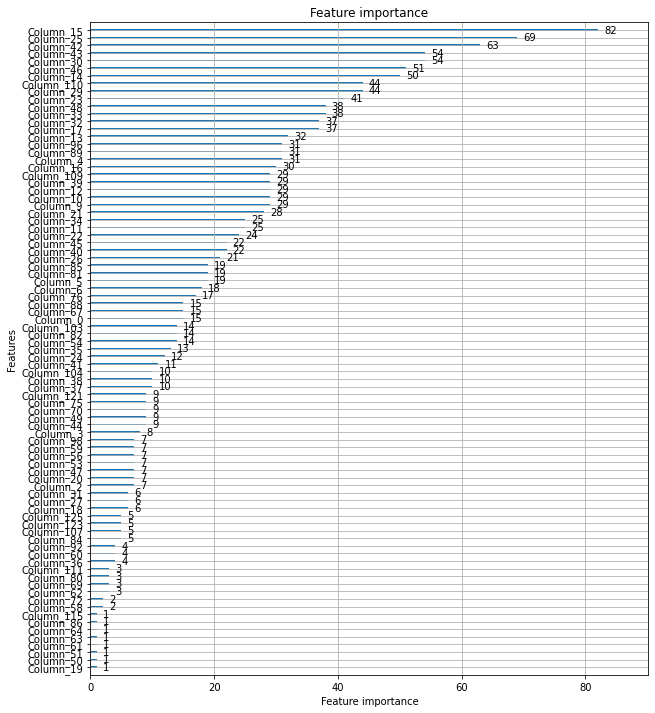

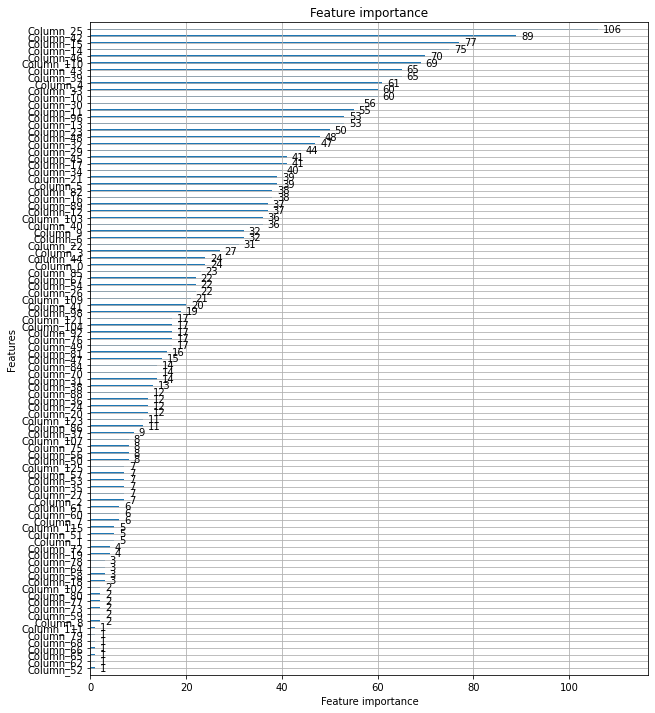

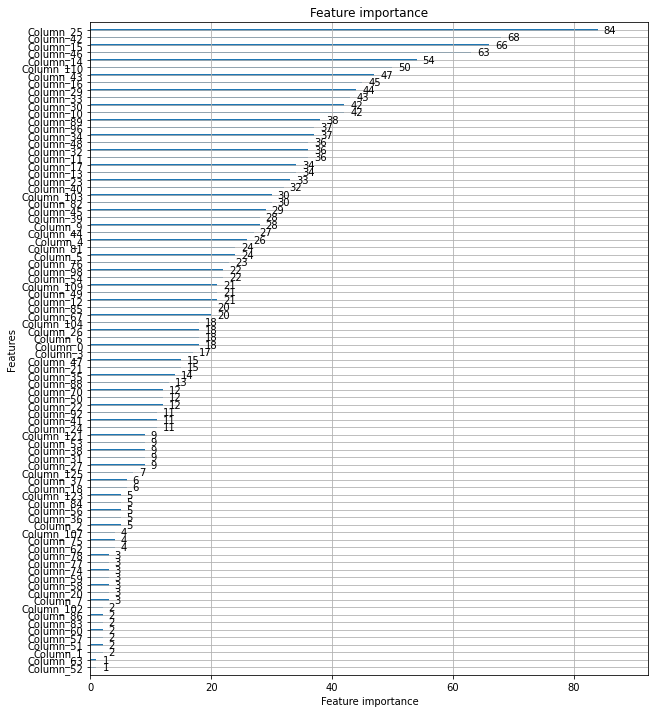

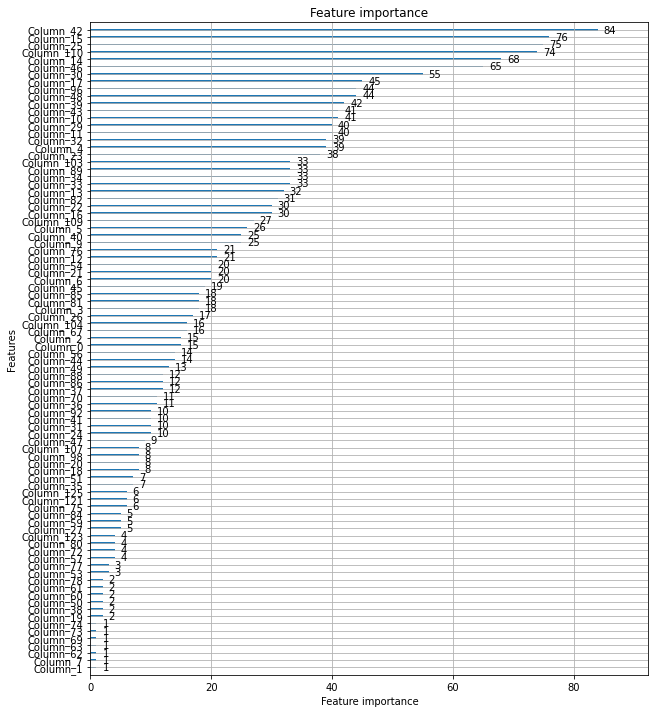

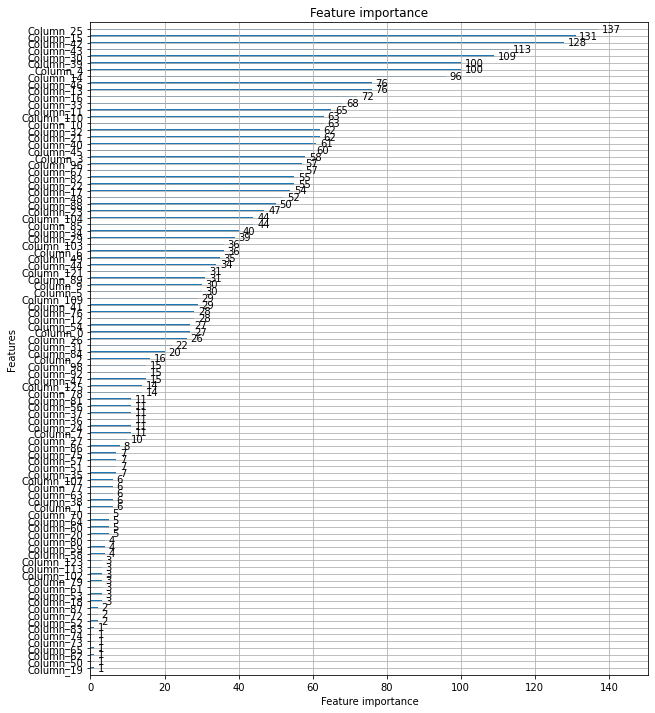

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

for model in models:
  fig, ax = plt.subplots(figsize=(10, 12))
  plot_importance(model, ax=ax)